In [1]:
import time
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from datetime import timedelta

%matplotlib inline

In [2]:
X_path = "../data/features_cnn/X_te.txt"
Y_path = "../data/features_cnn/Y_te.txt"
X = np.loadtxt(X_path)
y = np.loadtxt(Y_path, dtype=int)

X = X[(y==5) | (y==6)]
y = y[(y==5) | (y==6)]

y[(y==5)] = 0
y[(y==6)] = 1



In [3]:
import tensorflow as tf
import numpy as np
import time
from dataset import DataSet

# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 100

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# try 2 styles
classes = ['realism', 'abstract-art']
num_classes = len(classes)

# batch size
batch_size = 32

# validation split
validation_size = .16

checkpointsPath = "./models"

def get_arr(y):
    y_arr = np.zeros((y.shape[0], num_classes))
    for i in range(y.shape[0]):
        val = y[i]
        arr = np.zeros((num_classes))
        arr[val] = 1
        y_arr[i,:] = arr
    return y_arr


def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def new_conv_layer(input,              
                   num_input_channels, 
                   filter_size,        
                   num_filters,       
                   use_pooling=True):
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    layer += biases
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = tf.nn.relu(layer)
    # keep_prob = 0.5
    # layer = tf.nn.dropout(layer, keep_prob)
    return layer, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

def new_fc_layer(input,          
                 num_inputs,     
                 num_outputs,    
                 use_relu=True): 
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)
    return layer


def build_model():
    x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
    x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
    y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
    y_true_cls = tf.argmax(y_true, axis=1)

    layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
    layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
    layer_conv3, weights_conv3 = new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)
    layer_flat, num_features = flatten_layer(layer_conv3)
    layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
    layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)
    y_pred = tf.nn.softmax(layer_fc2)
    y_pred_cls = tf.argmax(y_pred, axis=1)

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                        labels=y_true)
    cost = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return x, y_true, optimizer, y_pred_cls, layer_conv1, layer_conv2, layer_conv3




In [4]:
def test(X_te, y_te, idx):
    data_test = DataSet(X_te, get_arr(y_te), y_te, classes)

    x, y_true, optimizer, y_pred_cls, layer_conv1, layer_conv2, layer_conv3 = build_model()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        checkPoint = tf.train.get_checkpoint_state(checkpointsPath + "/model-realism-abstract")
        # if have checkPoint, restore checkPoint
        if checkPoint and checkPoint.model_checkpoint_path:
            print(checkPoint.model_checkpoint_path)
            saver.restore(sess, checkPoint.model_checkpoint_path)
            print("restored %s" % checkPoint.model_checkpoint_path)
        else:
            print("no checkpoint found!")
            exit(0)

        num_test = len(data_test.images)
        cls_pred = np.zeros(shape=num_test, dtype=np.int)

        i = 0

        while i < num_test:
            j = min(i + batch_size, num_test)

            images = data_test.images[i:j, :]
            labels = data_test.labels[i:j, :]
            feed_dict = {x: images,
                         y_true: labels}

            cls_pred[i:j] = sess.run(y_pred_cls, feed_dict=feed_dict)
            i = j

        cls_true = np.array(data_test.label_texts)
        cls_pred = np.array([classes[x] for x in cls_pred]) 

        correct = (cls_true == cls_pred)
        correct_sum = correct.sum()
        acc = float(correct_sum) / num_test

        msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
        print(msg.format(acc, correct_sum, num_test))
        
        plot_conv_layer(x, layer=layer_conv1, image=X_te[idx, None], session=sess)
        plot_conv_layer(x, layer=layer_conv2, image=X_te[idx, None], session=sess)
        plot_conv_layer(x, layer=layer_conv3, image=X_te[idx, None], session=sess)


In [5]:
def plot_image(image):
    plt.imshow(image.reshape(img_size, img_size, num_channels),
               interpolation='nearest')
    plt.show()

In [6]:
def plot_conv_layer(x, layer, image, session):
#     image = image.reshape(img_size_flat)
    print(image.shape)
    print(x)
    
    feed_dict = {x: image}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


In [7]:
print("Loaded data!")
print("Data_size = " + str(y.shape[0]))
print("label 0: " + str(y[(y==0)].shape[0]))
print("label 1: " + str(y[(y==1)].shape[0]))
print(X[0, None].shape)






Loaded data!
Data_size = 221
label 0: 120
label 1: 101
(1, 30000)


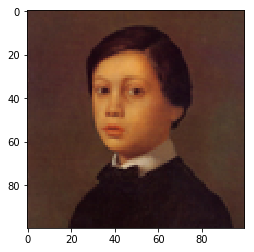

0


In [11]:
plot_image(X[4].reshape((100, 100, 3)))
print(y[4])

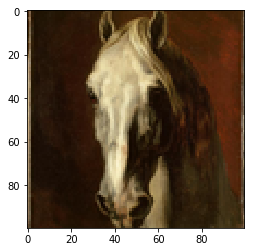

genrating...
./models/model-realism-abstract/model-15
INFO:tensorflow:Restoring parameters from ./models/model-realism-abstract/model-15
restored ./models/model-realism-abstract/model-15
Accuracy on Test-Set: 86.4% (191 / 221)
(1, 30000)
Tensor("x:0", shape=(?, 30000), dtype=float32)


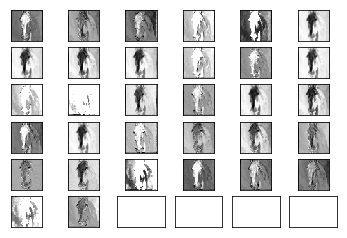

(1, 30000)
Tensor("x:0", shape=(?, 30000), dtype=float32)


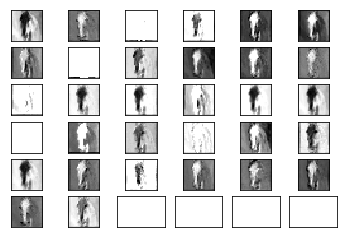

(1, 30000)
Tensor("x:0", shape=(?, 30000), dtype=float32)


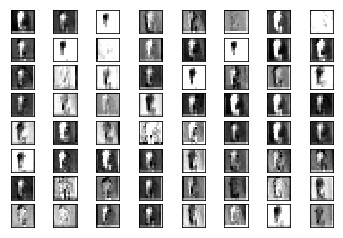

In [9]:
idx = 2

plot_image(X[idx].reshape((100, 100, 3)))
print("genrating...")
test(X, y, idx)